# MML 3 - Finding and working with data from the GeoDB

In this notebook, we see how we can access the GeoDB, how we can browse in it for data, how to access it and finally work with it a bit.
For convenience, we start straight away with some necessary imports.

In [1]:
from xcube_geodb.core.geodb import GeoDBClient

import matplotlib.pyplot as plt

import pandas as pd

from ipyleaflet import Map, basemaps, GeoData, Polygon
from shapely import box, intersects

The backbone of the geoDB is a postgres database that may be accessed via the geo db client. It requires you to state the url of the postgres service and credentials, but these may be kept as environment variables so you don't have to type them in everytime - as is the case here.

In [2]:
geodb = GeoDBClient()

We check whether the connection could be established.

In [3]:
geodb.whoami

'geodb_doors-user'

A database may contain several data collections. As the database at hand contains more than DOORS databases, we will restrict it to only show those.

In [4]:
df = geodb.get_my_collections()
doors_collections = df[df["owner"].str.contains("doors")==True]
doors_collections

,owner,database,collection
0,geodb_doors-io-bas-admin,aeronet-oc,Galata platform(Version 3 SEAPRISM Processing)
1,geodb_doors-io-bas-admin,aeronet-oc,Gloria platform (Version 3 SEAPRISM Processing)
2,geodb_doors-io-bas-admin,aeronet-oc,Section 7 (Version 3 SEAPRISM Processing)
19,geodb_doors-io-bas-admin,black_sea_ARGO,WMO1902575
20,geodb_doors-io-bas-admin,black_sea_ARGO,WMO3901852
...,...,...,...
1037,geodb_doors-io-bas-admin,water-quality,ANEMONE_CHL_2019_2020
1038,geodb_doors-io-bas-admin,water-quality,ANEMONE_Nutrients_2019_2020
1039,geodb_doors-io-bas-admin,water-quality,EMBLAS_CHL_2016_2019
1040,geodb_doors-io-bas-admin,water-quality,EMBLAS_Nutrients_2016_2019


This gives us a list of 105 collections, organised in databases. At this point, it can be overwhelming as we have at best a vague idea of the contents. For now, let's see which databases and collections are available:

In [5]:
doors_collections.database.unique()

array(['aeronet-oc', 'black_sea_ARGO', 'doors-bc-geoecomar', 'doors',
       'DOORS_Cruise_1_IO-BAS', 'DOORS_Cruise_1_USTIR',
       'DOORS_Cruise_2_Leg_1_IO-BAS', 'DOORS_Cruise_2_Leg_2_IO-BAS',
       'DOORS_Cruise_2_USTIR', 'DOORS_Cruise_3_IO-BAS', 'doors-geoecomar',
       'doors-io-bas', 'io-bas', 'ISMAR_CNR_Rome', 'Varna_Lakes',
       'water-quality'], dtype=object)

In [6]:
doors_collections.collection.unique()

array(['Galata platform(Version 3 SEAPRISM Processing)',
       'Gloria platform (Version 3 SEAPRISM Processing)',
       'Section 7 (Version 3 SEAPRISM Processing)', 'WMO1902575',
       'WMO3901852', 'WMO3901854', 'WMO3901855', 'WMO3902004',
       'WMO3902005', 'WMO3902006', 'WMO3902461', 'WMO4903711',
       'WMO5906866', 'WMO6900803', 'WMO6900804', 'WMO6900805',
       'WMO6900807', 'WMO6901828', 'WMO6901831', 'WMO6901832',
       'WMO6901833', 'WMO6901834', 'WMO6901866', 'WMO6901895',
       'WMO6901896', 'WMO6901899', 'WMO6901900', 'WMO6901959',
       'WMO6901961', 'WMO6901962', 'WMO6903228', 'WMO6903271',
       'WMO6903766', 'WMO6903782', 'WMO6903865', 'WMO6903866',
       'WMO6903867', 'WMO6990663', 'WMO7900590', 'WMO7900591',
       'WMO7900592', 'WMO7900593', 'WMO7900594', 'WMO7900595',
       'WMO7900596', 'WMO7901065', 'WMO7902191', 'EuxRo03 Iulie 2021_RR',
       'BG_Coastal', 'BG_eez', 'BG_Open', 'BG_Shelf', 'BSWQDB_1',
       'bulgarian_black_sea', 'Aerosol_Optical_Th

One way to get more information about the dataset is to use the function `get_collection_info`. Note that you need to specify both the collection and the database.

In [7]:
geodb.get_collection_info("EMBLAS_CHL_2016_2019", database="water-quality")

{'required': ['id', 'geometry'],
 'properties': {'id': {'description': 'Note:\nThis is a Primary Key.<pk/>',
   'format': 'integer',
   'type': 'integer'},
  'created_at': {'default': 'CURRENT_TIMESTAMP',
   'format': 'timestamp with time zone',
   'type': 'string'},
  'modified_at': {'format': 'timestamp with time zone', 'type': 'string'},
  'geometry': {'format': 'public.geometry(Geometry,4326)', 'type': 'string'},
  'cruise': {'format': 'text', 'type': 'string'},
  'station': {'format': 'text', 'type': 'string'},
  'longitude': {'format': 'double precision', 'type': 'number'},
  'latitude': {'format': 'double precision', 'type': 'number'},
  'day': {'format': 'integer', 'type': 'integer'},
  'month': {'format': 'integer', 'type': 'integer'},
  'year': {'format': 'integer', 'type': 'integer'},
  'sampling depth [m]': {'format': 'double precision', 'type': 'number'},
  'chl-a [mg/m3]': {'format': 'double precision', 'type': 'number'},
  'provider_data_collector': {'format': 'text', 't

This gives some information about the dataset, but looking this up for each collection can be cumbersome. To overcome this, we can come up with auxiliary functions. This one for example allows to search for collections that have certain variables:

In [8]:
def find_collections_with_var(var_name: str, database: str = ""):
    count = 0
    for index, collection_row in doors_collections.iterrows():
        if database not in collection_row['database']:
            continue
        num_rows = geodb.count_collection_rows(collection_row.collection, database=collection_row.database)
        if num_rows > 100000:
            gdf = geodb.get_collection_pg(
                collection_row.collection, where="id=0", database=collection_row.database
            )
        else:
            gdf = geodb.get_collection(collection_row.collection, database=collection_row.database)
        for column in list(gdf.columns):            
            if var_name in column:
                print(f'Database: {collection_row.database} / Collection: {collection_row.collection} / Variable: {column}')
                count += 1
                break
    print(f"Found {count} collections")

Note that in the function above we are making calls to the geodb: With `get_collection` can open any collection, with `get_collection_pg` we can additionally pass an sql statement to apply a filter - in the case above, this is done to only get a subset of the collection.

Let's use the function now to look for, say, chlorophyll variables. We restrict this to the aeronet-oc database to speed it a bit up.

In [9]:
find_collections_with_var("chlorophyll", database="aeronet-oc")

Database: aeronet-oc / Collection: Galata platform(Version 3 SEAPRISM Processing) / Variable: chlorophyll-a
Database: aeronet-oc / Collection: Gloria platform (Version 3 SEAPRISM Processing) / Variable: chlorophyll-a
Database: aeronet-oc / Collection: Section 7 (Version 3 SEAPRISM Processing) / Variable: chlorophyll-a
Found 3 collections


Another way to browse for collections is by defining an area of interest. Let's define one like this:

In [10]:
x_min = 28.5
y_min = 41.5
x_max = 29.5
y_max = 42
box_of_interest = box(x_min, y_min, x_max, y_max)

As a next step, we would like to plot this box on a map to validate. For this, we can define a map.

In [11]:
center = [box_of_interest.centroid.y, box_of_interest.centroid.x]
zoom = 8
m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)

We can place the area on the map using the following code:

In [12]:
x_min, y_min, x_max, y_max = box_of_interest.bounds
polygon = Polygon(
    locations= [
        [(y_min, x_min), (y_max, x_min), (y_max, x_max), (y_min, x_max)]
    ],
    color="green"
)
m.add(polygon)

Map(center=[41.75, 29.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

When we are fine with the area of interest, we can use it to compare against the bounding boxes of the collections. We define another auxiliary function to find any collection that at least partly lies within our area of interest.

In [13]:
def intersects_box(bbox: Polygon):
    for index, collection_row in doors_collections.iterrows():
        collection_bbox = geodb.get_collection_bbox(collection_row.collection, database=collection_row.database)
        if collection_bbox is not None:
            xmin, ymin, xmax, ymax = collection_bbox
            collection_box = box(ymin, xmin, ymax, xmax)
            if intersects(box_of_interest, collection_box):
                print(f'Database: {collection_row.database} / Collection: {collection_row.collection}')

We can then simply call the function like this:

In [14]:
intersects_box(box_of_interest)

Database: black_sea_ARGO / Collection: WMO1902575
Database: black_sea_ARGO / Collection: WMO3901852
Database: black_sea_ARGO / Collection: WMO3901854
Database: black_sea_ARGO / Collection: WMO3901855
Database: black_sea_ARGO / Collection: WMO3902004
Database: black_sea_ARGO / Collection: WMO3902005
Database: black_sea_ARGO / Collection: WMO3902006
Database: black_sea_ARGO / Collection: WMO3902461
Database: black_sea_ARGO / Collection: WMO4903711
Database: black_sea_ARGO / Collection: WMO5906866
Database: black_sea_ARGO / Collection: WMO6900803
Database: black_sea_ARGO / Collection: WMO6900804
Database: black_sea_ARGO / Collection: WMO6900805
Database: black_sea_ARGO / Collection: WMO6900807
Database: black_sea_ARGO / Collection: WMO6901828
Database: black_sea_ARGO / Collection: WMO6901831
Database: black_sea_ARGO / Collection: WMO6901832
Database: black_sea_ARGO / Collection: WMO6901833
Database: black_sea_ARGO / Collection: WMO6901834
Database: black_sea_ARGO / Collection: WMO6901866


Now, we know that only part of the collection lies within the area of interest. So, how many features does this concern? With the following request, we can find out:

In [15]:
geodb.count_collection_by_bbox("ANEMONE_Nutrients_2019_2020", database="water-quality", bbox=box_of_interest.bounds)

,ct
0,40


That is 40 features from the collection within the area of interest. That is good, we may now open the collection with taking the area into account.

In [16]:
gdf_by_bbox = geodb.get_collection_by_bbox("ANEMONE_Nutrients_2019_2020", database="water-quality", bbox=box_of_interest.bounds)
gdf_by_bbox

,id,created_at,modified_at,geometry,cruise,station,longitude,latitude,date,station depth [m],parameter,concentration,value,unit,organization,provider_data_collector,timestamp
0,1499,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Ammonia nitrogen,Individual Value,0.3712,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00
1,1500,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Phosphate,Less than LoD,0.6195,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00
2,1501,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Silicon,Less than LoD,1.6851,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00
3,1502,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Total nitrogen,Individual Value,8107.2375,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00
4,1503,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Total phosphorus,Individual Value,5.3942,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00
5,1504,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Ammonia nitrogen,Individual Value,1.4257,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00
6,1505,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Phosphate,Less than LoD,0.6195,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00
7,1506,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Silicon,Less than LoD,1.6851,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00
8,1507,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Total nitrogen,Individual Value,8227.1753,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00
9,1508,2023-03-20T12:58:10.625488+00:00,None,POINT (28.61080 41.71150),Joint Cruise,ANE-TR-4,28.6108,41.7115,05.10.2019,86,Total phosphorus,Individual Value,5.0575,µg/l,NIMRD,http://database.blackseadb.org/,2019-10-05 12:00:00


There are our 40 features. We now may add them to the map.

In [17]:
geo_data = GeoData(
    geo_dataframe = gdf_by_bbox,
    style={'color': 'black', 'radius':6, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 5, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
    name = 'Release'
)
m.add(geo_data)

Map(bottom=24589.0, center=[41.75, 29.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

We see there are two points visible - this makes sense, as the collection lists data from two different stations at two different locations.

Now, what if we were not interested in the area but would like to filter for a variable? We can do so by applying the aforementioned `get_collection_pg` method, where we filter out all invalid ph values.

In [18]:
gdf_by_query = geodb.get_collection_pg("CTD_Profiles", database="DOORS_Cruise_3_IO-BAS", where="ph <> 'NaN'")
gdf_by_query

,id,created_at,modified_at,geometry,station,date,time [utc],latitude,longitude,depth [m],salinity [psu],temperature [˚c],fluorescence [mg/m^3],turbidity [ntu],oxygen [mg/l],ph,timestamp,provider_data_collector
0,1,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,1,18.7397,19.1970,0.2071,0.3280,8.9530,8.280,2024-06-02 09:21:00,https://geoecomar.ro/
1,2,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,2,18.7396,19.1750,0.0952,0.6214,8.5933,8.276,2024-06-02 09:21:00,https://geoecomar.ro/
2,3,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,3,18.7581,19.1184,0.0869,0.6608,8.1908,8.279,2024-06-02 09:21:00,https://geoecomar.ro/
3,4,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,4,18.7881,19.0749,0.1082,0.6502,7.9870,8.283,2024-06-02 09:21:00,https://geoecomar.ro/
4,5,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,5,18.8029,19.0301,0.1441,0.6500,7.7449,8.284,2024-06-02 09:21:00,https://geoecomar.ro/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,419,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1E,2024-06-02,11:30:00,43.601267,29.532583,88,19.6327,9.0877,0.0322,0.2592,4.4526,7.917,2024-06-02 11:30:00,https://geoecomar.ro/
419,420,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1E,2024-06-02,11:30:00,43.601267,29.532583,89,19.6326,9.0876,0.0320,0.2623,4.4558,7.917,2024-06-02 11:30:00,https://geoecomar.ro/
420,421,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1E,2024-06-02,11:30:00,43.601267,29.532583,90,19.6333,9.0865,0.0503,0.2592,4.4496,7.917,2024-06-02 11:30:00,https://geoecomar.ro/
421,422,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1E,2024-06-02,11:30:00,43.601267,29.532583,91,19.6313,9.0868,0.0547,0.2515,4.4275,7.907,2024-06-02 11:30:00,https://geoecomar.ro/


This leaves us with 423 elements. For the next task, where we want to create an aggregated time series, this is too little, so we request the full collection and do not consider ph there.

In [19]:
profiles_gdf = geodb.get_collection("CTD_Profiles", database="DOORS_Cruise_3_IO-BAS")
profiles_gdf

,id,created_at,modified_at,geometry,station,date,time [utc],latitude,longitude,depth [m],salinity [psu],temperature [˚c],fluorescence [mg/m^3],turbidity [ntu],oxygen [mg/l],ph,timestamp,provider_data_collector
0,1,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,1.0,18.7397,19.1970,0.2071,0.3280,8.9530,8.280,2024-06-02 09:21:00,https://geoecomar.ro/
1,2,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,2.0,18.7396,19.1750,0.0952,0.6214,8.5933,8.276,2024-06-02 09:21:00,https://geoecomar.ro/
2,3,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,3.0,18.7581,19.1184,0.0869,0.6608,8.1908,8.279,2024-06-02 09:21:00,https://geoecomar.ro/
3,4,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,4.0,18.7881,19.0749,0.1082,0.6502,7.9870,8.283,2024-06-02 09:21:00,https://geoecomar.ro/
4,5,2024-08-22T06:34:01.986416+00:00,None,POINT (29.53258 43.60127),MN256-1,2024-06-02,09:21:00,43.601267,29.532583,5.0,18.8029,19.0301,0.1441,0.6500,7.7449,8.284,2024-06-02 09:21:00,https://geoecomar.ro/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8447,8448,2024-08-22T06:34:15.103269+00:00,None,POINT (29.79667 42.60500),MN256-8B,2024-06-18,17:37:00,42.605000,29.796667,197.0,21.5480,8.8419,0.1236,0.5703,0.0340,NaN,2024-06-18 17:37:00,https://geoecomar.ro/
8448,8449,2024-08-22T06:34:15.103269+00:00,None,POINT (29.79667 42.60500),MN256-8B,2024-06-18,17:37:00,42.605000,29.796667,198.0,21.5535,8.8424,0.1236,0.5350,0.0340,NaN,2024-06-18 17:37:00,https://geoecomar.ro/
8449,8450,2024-08-22T06:34:15.103269+00:00,None,POINT (29.79667 42.60500),MN256-8B,2024-06-18,17:37:00,42.605000,29.796667,199.0,21.5572,8.8423,0.1236,0.5611,0.0340,NaN,2024-06-18 17:37:00,https://geoecomar.ro/
8450,8451,2024-08-22T06:34:15.103269+00:00,None,POINT (29.79667 42.60500),MN256-8B,2024-06-18,17:37:00,42.605000,29.796667,200.0,21.5610,8.8418,0.1236,0.5140,0.0340,NaN,2024-06-18 17:37:00,https://geoecomar.ro/


We want to create the time series for the following parameters:

In [20]:
parameters = ['temperature [˚c]', 'fluorescence [mg/m^3]', 'turbidity [ntu]', 'oxygen [mg/l]']

Now, we can browse through the individual dates in the dataset and derive the mean and standard deviation for each of these parametersfor that day.

In [21]:
dates = profiles_gdf["date"].unique()

dfs = []
for date in dates:
    d = {}
    d["date"] = [date]
    date_gdf = profiles_gdf[profiles_gdf["date"] == date]
    for parameter in parameters:
        d[f"{parameter}_mean"] = [date_gdf[parameter].mean()]
        d[f"{parameter}_std"] = [date_gdf[parameter].std()]
    df = pd.DataFrame(d)
    dfs.append(df)
stats_frame = pd.concat(dfs)
stats_frame

,date,temperature [˚c]_mean,temperature [˚c]_std,fluorescence [mg/m^3]_mean,fluorescence [mg/m^3]_std,turbidity [ntu]_mean,turbidity [ntu]_std,oxygen [mg/l]_mean,oxygen [mg/l]_std
0,2024-06-02,11.371415,3.604981,0.291058,0.331436,0.310306,0.171854,7.679870,2.637508
0,2024-06-06,9.391057,1.834677,0.224810,0.254507,0.703691,0.262997,1.894958,3.709946
0,2024-06-07,9.631460,2.455377,1.080370,0.577654,1.660385,0.300086,1.681979,3.581957
0,2024-06-08,10.256371,2.945439,0.229435,0.402488,0.742917,0.389915,4.574042,4.608013
0,2024-06-09,13.247096,4.685233,0.535544,0.540693,1.715193,0.966151,9.355859,0.352645
0,2024-06-13,9.565725,2.259924,0.211593,0.259299,0.617837,0.223980,2.655848,4.140424
0,2024-06-14,9.446523,2.182696,0.185645,0.191891,0.608205,0.272055,1.998967,3.778096
0,2024-06-17,9.338006,2.014883,0.202364,0.151817,0.566072,0.215905,1.073412,2.952978
0,2024-06-18,9.546442,2.542382,0.217826,0.209656,0.552738,0.150535,1.381365,3.293095


This table looks good, but a plot would look nicer. We can define a specific function for this:

In [22]:
def plot_stats(param: str):
    fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))
    t1 = stats_frame["date"]
    mean_field1 = stats_frame[f"{param}_mean"]
    std_field1 = stats_frame[f"{param}_std"]
    ax_stat.plot(t1, mean_field1, label=f"{param} mean")
    ax_stat.fill_between(
        t1,
        mean_field1 - std_field1,
        mean_field1 + std_field1,
        alpha=0.3,
        label=f"{param} standard deviation",
    )
    ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax_stat.tick_params(axis="y", labelsize=12)
    ax_stat.set_xlabel("Date", size=15)
    ax_stat.set_ylabel(param, size=15)
    ax_stat.legend(loc="lower right", prop={"size": 12})
    ax_stat.set_title(f"{param} time series", fontsize=20)
    for label in ax_stat.get_xticklabels()[1::2]:
        label.set_visible(False)

... and then simply call it for any of the parameters:

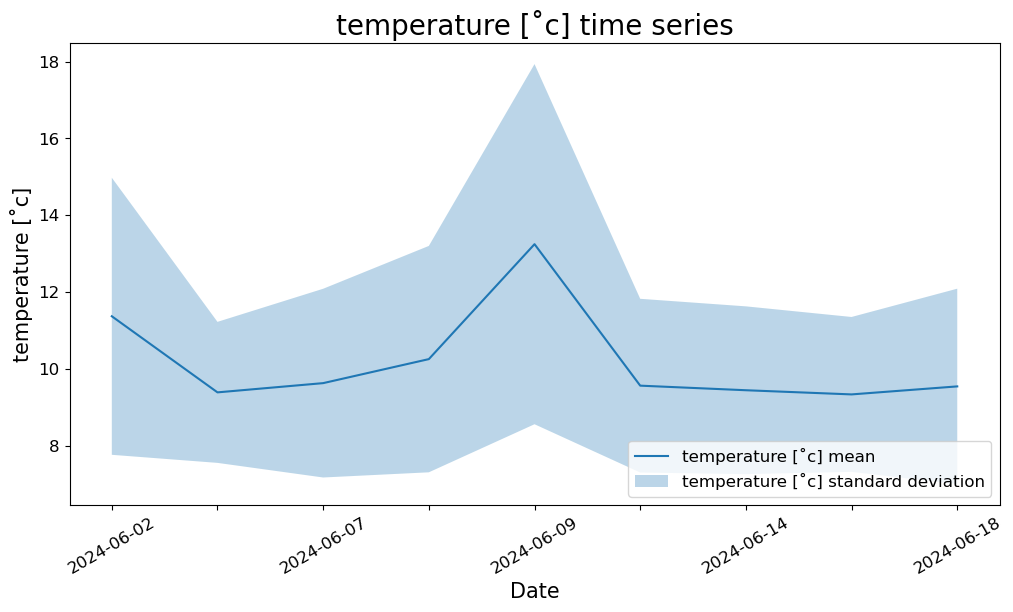

In [23]:
plot_stats("temperature [˚c]")